# Data Wrangling Report

Two sets of data were obtained for this project, each of them with data ranging from 2005 to 2017. One set, obtained from the Environmental Protection Agency (EPA), consisted of air quality data that had hourly ozone concentrations for a measuring station in Essex, MD. The other set, obtained from the National Oceanic and Atmospheric Administration (NOAA), consisted of hourly weather observations for Martin State Airport in Maryland, which located 3 miles from Essex. 

The objective of this data wrangling process was to ensure that for both datasets, observations at each hour would be available for the duration of the time period being analyzed, so that they can be merged into one dataframe containing both the measured ozone levels and the weather observations for each hour.

### Weather data

The first step was to import the necessary packages for this process.

In [1]:
#Import packages
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import datetime
import pickle

Next, the weather dataset was uploaded to the Jupyter notebook as a dataframe. The appropriate delimiter was used so that the dataframe can be recognized.

In [2]:
#Upload weather data as dataframe
wx = pd.read_csv('Martin_st_hourly_obs.txt', delim_whitespace = True, 
                 low_memory=False)

As seen below, the dataframe is very messy, with many variables that are uneecessary for the analysis. There were 33 columns and 165,778 rows in this set. A great deal of cleaning was necessary.

In [3]:
wx.head()

,USAF,WBAN,YR--MODAHRMN,DIR,SPD,GUS,CLG,SKC,L,M,...,SLP,ALT,STP,MAX,MIN,PCP01,PCP06,PCP24,PCPXX,SD
0,724067,93744,200601010000,***,0,***,79,BKN,*,*,...,******,29.83,******,***,***,*****,*****,*****,*****,**
1,724067,93744,200601010045,***,0,***,70,BKN,*,*,...,******,29.84,1009.7,***,***,*****,*****,*****,*****,**
2,724067,93744,200601010155,***,0,***,80,OVC,*,*,...,******,29.84,1009.7,***,***,*****,*****,*****,*****,**
3,724067,93744,200601011046,***,***,***,60,***,*,*,...,******,29.98,1014.4,***,***,*****,*****,*****,*****,**
4,724067,93744,200601011145,320,5,***,50,BKN,*,*,...,******,30.01,1015.4,***,***,*****,*****,*****,*****,**


In [4]:
wx.shape

(165778, 33)

As shown below, the only weather variables being chosen for this analysis (along with time) were wind speed, visibility, temperature, dew point, and atmospheric pressure (measured in millibars).

In [5]:
#Select relevant columns
wx = wx.loc[:, ['YR--MODAHRMN', 'SPD', 'VSB', 'TEMP', 'DEWP', 'STP']]
wx.head()

,YR--MODAHRMN,SPD,VSB,TEMP,DEWP,STP
0,200601010000,0,5.0,36,36,******
1,200601010045,0,5.0,36,36,1009.7
2,200601010155,0,5.0,36,34,1009.7
3,200601011046,***,****,41,32,1014.4
4,200601011145,5,10.0,41,32,1015.4


Other than the `'YR--MODAHRMN'` column (with a clumsy name for the datatime column), the columns appeared to show no clear datatype. All of the following variables are numeric in nature, so they were converted using the `pd.to_numeric()` function, with the errors coerced into `NaN` values. Also, the `'YR--MODAHRMN'` column was renamed to `'TIME'`, and set as the DatetimeIndex for this dataframe.

In [6]:
wx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165778 entries, 0 to 165777
Data columns (total 6 columns):
YR--MODAHRMN    165778 non-null int64
SPD             165778 non-null object
VSB             165778 non-null object
TEMP            165778 non-null object
DEWP            165778 non-null object
STP             165778 non-null object
dtypes: int64(1), object(5)
memory usage: 7.6+ MB


In [7]:
#Rename first column
wx.rename(columns = {'YR--MODAHRMN':'TIME'}, inplace = True)
#Convert to datetime,
wx['TIME'] = pd.to_datetime(wx.TIME, format = "%Y%m%d%H%M")
#Set index
wx.set_index('TIME', inplace = True)
#Convert data of all remaining columns to floats
wx = wx.apply(pd.to_numeric, errors='coerce')

As a result of these changes, all variables were converted to floats, with the missing values now being recognized as `NaN`. They were counted using the `wx.isnull().sum()` function

In [8]:
wx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165778 entries, 2006-01-01 00:00:00 to 2017-12-31 23:45:00
Data columns (total 5 columns):
SPD     165370 non-null float64
VSB     165182 non-null float64
TEMP    163431 non-null float64
DEWP    163287 non-null float64
STP     145852 non-null float64
dtypes: float64(5)
memory usage: 7.6 MB


In [9]:
wx.head()

,SPD,VSB,TEMP,DEWP,STP
TIME,,,,,
2006-01-01 00:00:00,0.0,5.0,36.0,36.0,NaN
2006-01-01 00:45:00,0.0,5.0,36.0,36.0,1009.7
2006-01-01 01:55:00,0.0,5.0,36.0,34.0,1009.7
2006-01-01 10:46:00,NaN,NaN,41.0,32.0,1014.4
2006-01-01 11:45:00,5.0,10.0,41.0,32.0,1015.4


In [10]:
#Count missing values
print 'Number of missing values for each variable:'
print(wx.isnull().sum())

Number of missing values for each variable:
SPD       408
VSB       596
TEMP     2347
DEWP     2491
STP     19926
dtype: int64


In this dataset, the Greenwich time (GMT/UTC) was used for the observations, so they were recognized as such with `tz_localize()`, and then converted to local time (US/Eastern) using `tz_convert()`. The times were then converted back to naive times with `tz_localize(None)`.

In [11]:
#Convert timezone from GMT to Eastern US
wx = wx.tz_localize(tz='GMT')
wx = wx.tz_convert(tz='US/Eastern')

wx.head()

,SPD,VSB,TEMP,DEWP,STP
TIME,,,,,
2005-12-31 19:00:00-05:00,0.0,5.0,36.0,36.0,NaN
2005-12-31 19:45:00-05:00,0.0,5.0,36.0,36.0,1009.7
2005-12-31 20:55:00-05:00,0.0,5.0,36.0,34.0,1009.7
2006-01-01 05:46:00-05:00,NaN,NaN,41.0,32.0,1014.4
2006-01-01 06:45:00-05:00,5.0,10.0,41.0,32.0,1015.4


In [12]:
#Convert times to naive
wx = wx.tz_localize(None)
wx.head()

,SPD,VSB,TEMP,DEWP,STP
TIME,,,,,
2005-12-31 19:00:00,0.0,5.0,36.0,36.0,NaN
2005-12-31 19:45:00,0.0,5.0,36.0,36.0,1009.7
2005-12-31 20:55:00,0.0,5.0,36.0,34.0,1009.7
2006-01-01 05:46:00,NaN,NaN,41.0,32.0,1014.4
2006-01-01 06:45:00,5.0,10.0,41.0,32.0,1015.4


Next, the observations were resampled so they could be cleanly shown for every hour, and then they were counted hourly to see whether each hour had an observation. This information was stored in a new `obscount` dataframe.

In [13]:
#Resample observations
obscount = wx.resample('h').count()
obscount.head()

,SPD,VSB,TEMP,DEWP,STP
TIME,,,,,
2005-12-31 19:00:00,2,2,2,2,1
2005-12-31 20:00:00,1,1,1,1,1
2005-12-31 21:00:00,0,0,0,0,0
2005-12-31 22:00:00,0,0,0,0,0
2005-12-31 23:00:00,0,0,0,0,0


In the `obscount` dataframe, a new column, `'OBS'`, was created for the purpose of counting the maximum number of observations for any variable in each hour. The `.max()` function was used, with the axis set to 1 so that the maximum value in each row would be included. Also, the `.unique()` function was used to show the entire range of the number of observations per hour, throughout the entire dataset. 

In [14]:
#New obscount column
obscount['OBS'] = obscount.max(axis=1)
obscount = obscount.loc[:, ['OBS']]
obscount.head()

,OBS
TIME,
2005-12-31 19:00:00,2
2005-12-31 20:00:00,1
2005-12-31 21:00:00,0
2005-12-31 22:00:00,0
2005-12-31 23:00:00,0


In [15]:
#Show full range of obs/hr
obscount.OBS.unique()

array([2, 1, 0, 3, 4, 6, 5, 7])

The values of zero were replaced with null values, so that the total number of hours per day with observations could be counted using the `.resample('D')` function. This function does not count the total number of observations in a day. It counts the total number of hours in a day in which observations are recorded, so every valid value is counted. With the replacement of values equal to `0` with `NaN`, an accurate number of hours with observations per day could be tallied.

As seen in the head of the dataframe, all of the early days had many missing hours for all variables being studied. As a result, the number of hours with observations per day throughout the entire dataset was graphed, so that this issue could be visualized.

In [16]:
#Replace 0 as NaN
obscount.replace(0, np.NaN, inplace=True)
#Resample obscount to daily
obscount = obscount.resample('D').count()
obscount.head()

,OBS
TIME,
2005-12-31,2
2006-01-01,17
2006-01-02,17
2006-01-03,16
2006-01-04,13


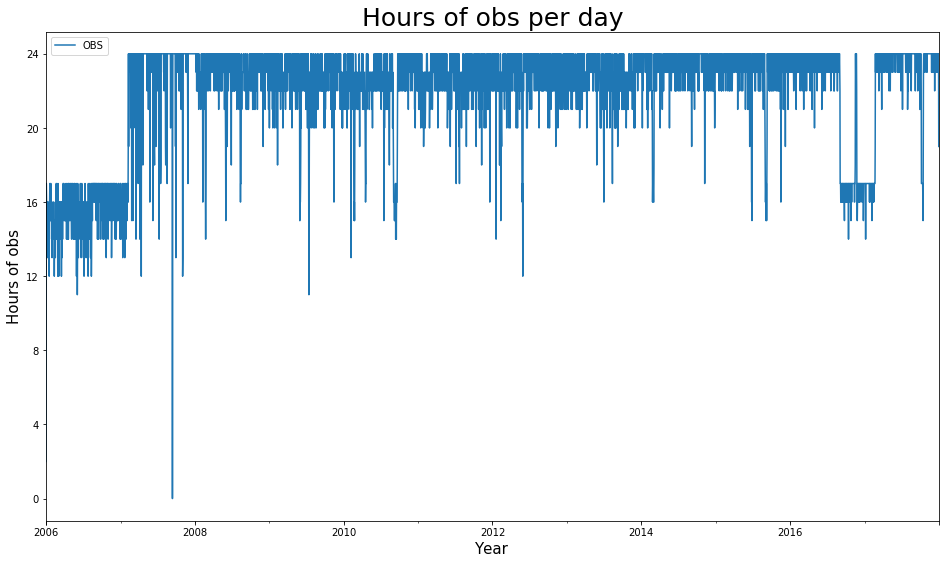

In [17]:
#Plot daily # of hours of obs/day for full time period
_ = plt.rcParams['figure.figsize'] = [16, 9]
_ = obscount.plot()
_ = plt.title('Hours of obs per day', fontsize = 25)
_ = plt.xlabel('Year', fontsize = 15)
_ = plt.ylabel('Hours of obs', fontsize = 15)
_ = plt.yticks([0, 4, 8, 12, 16, 20, 24])

As seen in the above graph, all of 2006 and part of 2007 consistently had at least 7 hours per day missing in the observations. Also, a shorter, but similar period was found from late 2016 to early 2017. To minimize this problem, the time period being studied was truncated to the entirety of 2008 to 2015.

Another graph with the trimmed time period was plotted below to show the difference. This time period had occassional missing values (as would most datasets), but no consistent period of missing hours was found.

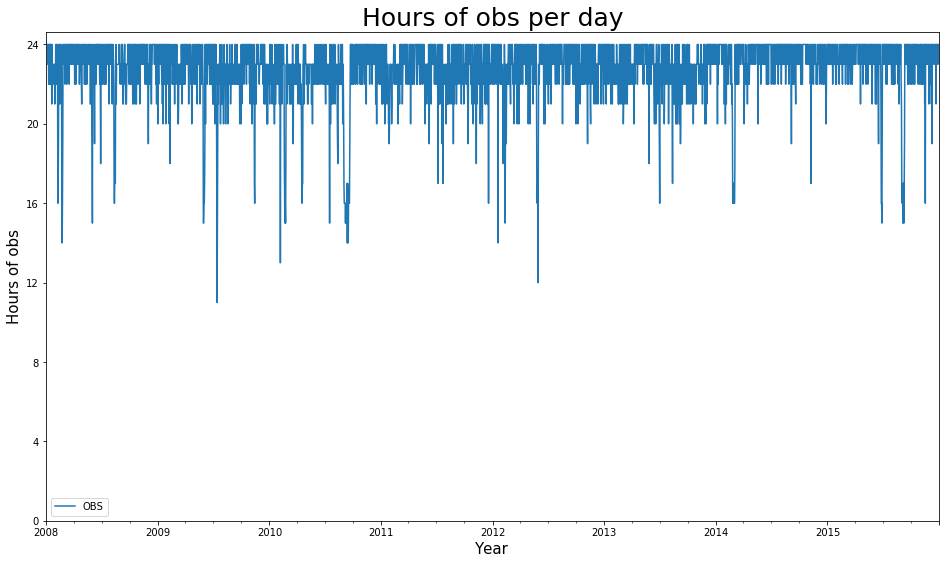

In [18]:
#Filter data to 2008 through 2015
obscount = obscount['2008-01-01':'2015-12-31']
#Plot the revised data
_ = plt.rcParams['figure.figsize'] = [16, 9]
_ = obscount.plot()
_ = plt.title('Hours of obs per day', fontsize = 25)
_ = plt.xlabel('Year', fontsize = 15)
_ = plt.ylabel('Hours of obs', fontsize = 15)
_ = plt.yticks([0, 4, 8, 12, 16, 20, 24])

As a result of the `obscount` plots and the successful truncation of data, the same time period was applied to the original dataset of weather obserations. Significant numbers of missing values were still found for each variable, but since most days did not have more than a few missing hours, an interpolation was a reliable solution.

In [19]:
#Filter weather data
wx = wx['2008-01-01':'2015-12-31']

In [20]:
#Count null values
print 'Number of missing values for each variable:'
print(wx.isnull().sum())

Number of missing values for each variable:
SPD      316
VSB      427
TEMP    2297
DEWP    2391
STP     5496
dtype: int64


To interpolate this data, a new dataframe `wx2` consisting of every hour from 2008 to 2015 was created, under the singular column `'TIME'`. The index of the initial `wx` dataframe was reset, so that the datetimes (`'TIME'`) could be used as a column.

In [21]:
#Create new dataframe with round hourly values 
wx.reset_index(inplace = True)
wx2 = pd.DataFrame(pd.date_range(start = '2008-01-01 00:00:00', 
                                 end = '2015-12-31 23:00:00', freq = '1h'))
wx2.columns = ['TIME']
wx2.head()

,TIME
0,2008-01-01 00:00:00
1,2008-01-01 01:00:00
2,2008-01-01 02:00:00
3,2008-01-01 03:00:00
4,2008-01-01 04:00:00


A `for` loop was used to replicate all the column names of the `wx` dataframe, but without any data. However, the data types of those columns were set to float, so that any data that gets appended would recognized as numeric. 

Afterwords, a new column `'stamped'` in `wx2` was created, with the value being set to 1, so that every row of this original `wx2` dataframe would be recognized once the data from the original `wx` dataframe is appended.

In [22]:
#Replicate columns from original dataframe
for col in wx.columns[1:]:
    wx2[col] = None
    wx2[col] = wx2[col].astype(float)
wx2['stamped'] = 1

In [23]:
wx2.head()

,TIME,SPD,VSB,TEMP,DEWP,STP,stamped
0,2008-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1
1,2008-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1
2,2008-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,1
3,2008-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1
4,2008-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,1


Another dataframe, `wx_int`, was then created to include all the rows and data from both the original `wx` and the newly created `wx2`. The `'stamped'` column indicated which dataframe the row originated from, with values of 1 associated with the `wx2` dataframe, and values of 0 associated with the original `wx` dataframe. The rows were then sorted by time. 

In [24]:
#Append both dataframes into a new dataframe for interpolation and sort values chronologically
wx_int = wx.assign(stamped = 0).append(wx2, ignore_index = True).sort_values('TIME').set_index('TIME')

With all the rows of the `wx` and `wx2` dataframes sorted in chronological order, with the rows from `wx2` having null values but clean hourly timeframes, the dataframe was finally ready for interpolation. 

The interpolation was done in both directions, and all the hourly rows of the `wx2` dataframe were successfully filled in with values based on the data from the original `wx` dataframe. The values from `wx` were deleted, and then `wx_int` was made to be the new `wx` dataframe.

In [25]:
#Interpolate the weather data
wx_int.interpolate(limit_direction='both', inplace = True)
#Remove original values
wx_int = wx_int.query('stamped == 1').drop('stamped', 1)

#Use interpolated data as the new wx dataframe
wx = wx_int
wx.head()

,SPD,VSB,TEMP,DEWP,STP
TIME,,,,,
2008-01-01 00:00:00,8.0,10.0,41.0,39.0,1018.100000
2008-01-01 01:00:00,8.5,10.0,41.0,41.0,1017.250000
2008-01-01 02:00:00,8.5,10.0,42.0,41.0,1016.466667
2008-01-01 03:00:00,12.0,10.0,43.0,41.0,1015.050000
2008-01-01 04:00:00,13.5,10.0,43.0,42.0,1014.250000


In [26]:
wx.tail()

,SPD,VSB,TEMP,DEWP,STP
TIME,,,,,
2015-12-31 19:00:00,5.0,10.0,45.5,37.0,1019.715
2015-12-31 20:00:00,1.5,10.0,45.0,37.0,1019.985
2015-12-31 21:00:00,2.5,10.0,45.0,36.5,1020.255
2015-12-31 22:00:00,4.0,10.0,44.0,36.0,1020.525
2015-12-31 23:00:00,5.0,10.0,43.0,36.0,1020.930


The values in this interpolated dataframe were all floats, and every column needed for its values to either be rounded or expressed as integers. Once that was done, and once every column was confirmed to have no missing values, the data cleaning of the weather dataframe was finally complete.

In [27]:
#Round the values
wx[['SPD','TEMP','DEWP']] = wx[['SPD','TEMP','DEWP']].astype(int)
wx['VSB'] = wx['VSB'].round(1)
wx['STP'] = wx['STP'].round(1)

In [28]:
#Confirm no missing values
print 'Number of missing values for each variable:'
print(wx.isnull().sum())

Number of missing values for each variable:
SPD     0
VSB     0
TEMP    0
DEWP    0
STP     0
dtype: int64


*******

### Ozone data
The ozone dataset was uploaded as a dataframe. Although it was a plain text file, it had commas separating each value, so no delimiter needed to be specified. The date format was odd, so that column needed to be cleaned before setting it as an index.

In [29]:
#Load ozone dataframe
o3 = pd.read_csv('Essex_ozone_data.txt', low_memory=False)

In [30]:
o3.head()

,site,data_status,action_code,datetime,parameter,duration,frequency,value,unit,qc,poc,lat,lon,GISDatum,elev,method_code,mpc,mpc_value,uncertainty,qualifiers
0,840240053001,0.0,10.0,20060101T2300-0500,44201.0,60.0,0.0,0.002,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,47.0,1.0,0.005,NaN,NaN
1,840240053001,0.0,10.0,20060101T2200-0500,44201.0,60.0,0.0,0.001,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,47.0,1.0,0.005,NaN,NaN
2,840240053001,0.0,10.0,20060101T0000-0500,44201.0,60.0,0.0,0.001,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,47.0,1.0,0.005,NaN,NaN
3,840240053001,0.0,10.0,20060101T2000-0500,44201.0,60.0,0.0,0.003,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,47.0,1.0,0.005,NaN,NaN
4,840240053001,0.0,10.0,20060101T1900-0500,44201.0,60.0,0.0,0.002,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,47.0,1.0,0.005,NaN,NaN


The initialized dataframe contained 20 columns and 102,249 rows. The only columns of importance are the `'datetime'` column and the `'value'` column, the latter of which contains the ozone concentration measured in parts per million (ppm). Fortunately, there are no missing values for those two columns, with the exception of the final row, which is void of any values, as shown below. 

In [31]:
o3.tail()

,site,data_status,action_code,datetime,parameter,duration,frequency,value,unit,qc,poc,lat,lon,GISDatum,elev,method_code,mpc,mpc_value,uncertainty,qualifiers
102244,840240053001,1.0,10.0,20160905T1100-0500,44201.0,60.0,0.0,0.037,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,87.0,1.0,0.005,NaN,NaN
102245,840240053001,1.0,10.0,20160905T1200-0500,44201.0,60.0,0.0,0.039,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,87.0,1.0,0.005,NaN,NaN
102246,840240053001,1.0,10.0,20160905T0900-0500,44201.0,60.0,0.0,0.034,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,87.0,1.0,0.005,NaN,NaN
102247,840240053001,1.0,10.0,20160905T0800-0500,44201.0,60.0,0.0,0.030,7.0,0.0,1.0,39.310833,-76.474444,WGS84,5.0,87.0,1.0,0.005,NaN,NaN
102248,END OF FILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
o3.shape

(102249, 20)

In [33]:
o3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102249 entries, 0 to 102248
Data columns (total 20 columns):
site           102249 non-null object
data_status    102248 non-null float64
action_code    102248 non-null float64
datetime       102248 non-null object
parameter      102248 non-null float64
duration       102248 non-null float64
frequency      102248 non-null float64
value          102248 non-null float64
unit           102248 non-null float64
qc             102248 non-null float64
poc            102248 non-null float64
lat            102248 non-null float64
lon            102248 non-null float64
GISDatum       102248 non-null object
elev           102248 non-null float64
method_code    102248 non-null float64
mpc            102248 non-null float64
mpc_value      102248 non-null float64
uncertainty    0 non-null float64
qualifiers     471 non-null object
dtypes: float64(16), object(4)
memory usage: 15.6+ MB


In [34]:
o3.nunique()

site                2
data_status         2
action_code         1
datetime       102248
parameter           1
duration            1
frequency           1
value             126
unit                1
qc                  1
poc                 1
lat                 1
lon                 1
GISDatum            1
elev                1
method_code         2
mpc                 1
mpc_value           1
uncertainty         0
qualifiers          4
dtype: int64

After the brief inspection, the dataframe was filtered so that only the `'datetime'` and `'value'` columns were selected.

In [35]:
#Filter ozone dataframe
o3 = o3.loc[:, ['datetime', 'value']]
o3.head()

,datetime,value
0,20060101T2300-0500,0.002
1,20060101T2200-0500,0.001
2,20060101T0000-0500,0.001
3,20060101T2000-0500,0.003
4,20060101T1900-0500,0.002


In [36]:
o3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102249 entries, 0 to 102248
Data columns (total 2 columns):
datetime    102248 non-null object
value       102248 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB


The `'datetime'` column still needed to be cleaned. The reported times were local, so no time zone needed to be assigned. After the `'datetime'` column was cleaned, it was ready to be converted to a datetime object.

In [37]:
#Clean 'datetime' column
o3['datetime'] = o3.datetime.str.replace("T"," ")
o3['datetime'] = o3.datetime.str.replace("-0500","")

#Convert to datetime object
o3['datetime'] = pd.to_datetime(o3.datetime)
o3.head()

,datetime,value
0,2006-01-01 23:00:00,0.002
1,2006-01-01 22:00:00,0.001
2,2006-01-01 00:00:00,0.001
3,2006-01-01 20:00:00,0.003
4,2006-01-01 19:00:00,0.002


The `datetime` values were then arranged in chronological order, and the index was set to that column.

In [38]:
#Sort datetimes
o3.sort_values('datetime', inplace = True)

In [39]:
#Set index to datetime column
o3.set_index('datetime', inplace=True)

In [40]:
#Filter the data to match the time span of the weather data
o3 = o3['2008-01-01':'2015-12-31']

The `value` column was renamed to `ozone_ppm`, so that the column name could be more descriptive of the data. After the dataframe was confirmed to have no missing values, the ozone data was merged with the weather data into the dataframe `df`.

In [41]:
#Rename 'value' column
o3.rename(columns = {'value':'ozone_ppm'}, inplace = True)

In [42]:
o3.head()

,ozone_ppm
datetime,
2008-01-01 00:00:00,0.019
2008-01-01 01:00:00,0.020
2008-01-01 02:00:00,0.020
2008-01-01 03:00:00,0.019
2008-01-01 04:00:00,0.019


In [43]:
#Confirm no missing values
print 'Number of missing values for each variable:'
print(o3.isnull().sum())

Number of missing values for each variable:
ozone_ppm    0
dtype: int64


In [44]:
#Merge dataframes by index
df = o3.join(wx)

After the merge, the new dataframe `df` was confirmed to have no missing values, and was pickled so it could easily be loaded again in another notebook. The data wrangling is now complete.

In [45]:
#Confirm no missing values in joint dataframe
print 'Number of missing values for each variable:'
print(df.isnull().sum())

Number of missing values for each variable:
ozone_ppm    0
SPD          0
VSB          0
TEMP         0
DEWP         0
STP          0
dtype: int64


In [46]:
#pickle the data
df.to_pickle('weather_ozone')